# Genre Classification using Word2Vec and LSTM

## 1. Import Library

In [1]:
import nltk
from tswift import *
import random
import pandas as pd
from langdetect import detect
import requests
import heapq 

from nltk.tokenize import wordpunct_tokenize, blankline_tokenize
import spacy

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
from nltk.corpus import stopwords
from time import time 
from gensim.models import Word2Vec
import multiprocessing

from collections import namedtuple

import xmltodict
import pprint
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

Menyimpan random seed

In [3]:
pp = pprint.PrettyPrinter(indent=4)
RANDOM_SEED = 101

In [4]:
lyrics = pd.read_csv('lyrics_song_genres_15k.csv')
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artist         15000 non-null  object
 1   song_name      15000 non-null  object
 2   closest_genre  15000 non-null  object
 3   lyric          15000 non-null  object
 4   length_lyric   15000 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 586.1+ KB


In [5]:
lyrics.describe()

,length_lyric
count,15000.000000
mean,228.412333
std,127.623821
min,4.000000
25%,149.000000
50%,204.000000
75%,272.000000
max,2634.000000


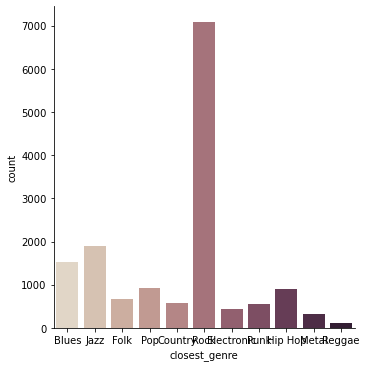

In [6]:
sns.catplot(x="closest_genre", kind="count", palette="ch:.25", data=lyrics)

In [7]:
lyrics.groupby('closest_genre')['song_name'].nunique().sort_values()

closest_genre
Reggae         102
Metal          283
Electronic     398
Country        506
Punk           519
Folk           619
Pop            824
Hip Hop        841
Blues         1326
Jazz          1423
Rock          6306
Name: song_name, dtype: int64

In [8]:
lyrics.groupby('closest_genre')['length_lyric'].max().sort_values()

closest_genre
Electronic     600
Reggae         722
Punk           724
Metal          809
Blues          845
Jazz           857
Country        923
Pop           1003
Rock          1451
Hip Hop       1543
Folk          2634
Name: length_lyric, dtype: int64

In [9]:
lyrics.groupby('closest_genre')['length_lyric'].min().sort_values()

closest_genre
Blues          4
Jazz           4
Electronic     5
Hip Hop        6
Punk           6
Rock           6
Pop            7
Folk          25
Metal         33
Country       57
Reggae        71
Name: length_lyric, dtype: int64

In [10]:
lyrics.groupby('closest_genre')['length_lyric'].describe()

,count,mean,std,min,25%,50%,75%,max
closest_genre,,,,,,,,
Blues,1524.0,224.795276,109.517494,4.0,154.0,204.0,271.0,845.0
Country,578.0,225.060554,104.462633,57.0,160.0,203.0,264.0,923.0
Electronic,434.0,234.119816,92.921256,5.0,165.5,226.5,286.0,600.0
Folk,675.0,233.680000,156.363937,25.0,157.0,206.0,268.5,2634.0
Hip Hop,891.0,440.120090,231.989433,6.0,252.0,417.0,611.0,1543.0
Jazz,1900.0,174.035263,91.202391,4.0,114.0,152.0,214.0,857.0
Metal,313.0,208.738019,93.930220,33.0,147.0,195.0,245.0,809.0
Pop,926.0,256.767819,119.436031,7.0,178.0,233.5,313.0,1003.0
Punk,548.0,219.016423,103.923232,6.0,144.0,205.0,273.0,724.0


Keterangan sebaran dari ukuran panjang lirik dari masing-masing genre

Blues              AxesSubplot(0.1,0.736957;0.235294x0.163043)
Country       AxesSubplot(0.382353,0.736957;0.235294x0.163043)
Electronic    AxesSubplot(0.664706,0.736957;0.235294x0.163043)
Folk               AxesSubplot(0.1,0.541304;0.235294x0.163043)
Hip Hop       AxesSubplot(0.382353,0.541304;0.235294x0.163043)
Jazz          AxesSubplot(0.664706,0.541304;0.235294x0.163043)
Metal              AxesSubplot(0.1,0.345652;0.235294x0.163043)
Pop           AxesSubplot(0.382353,0.345652;0.235294x0.163043)
Punk          AxesSubplot(0.664706,0.345652;0.235294x0.163043)
Reggae                 AxesSubplot(0.1,0.15;0.235294x0.163043)
Rock              AxesSubplot(0.382353,0.15;0.235294x0.163043)
dtype: object

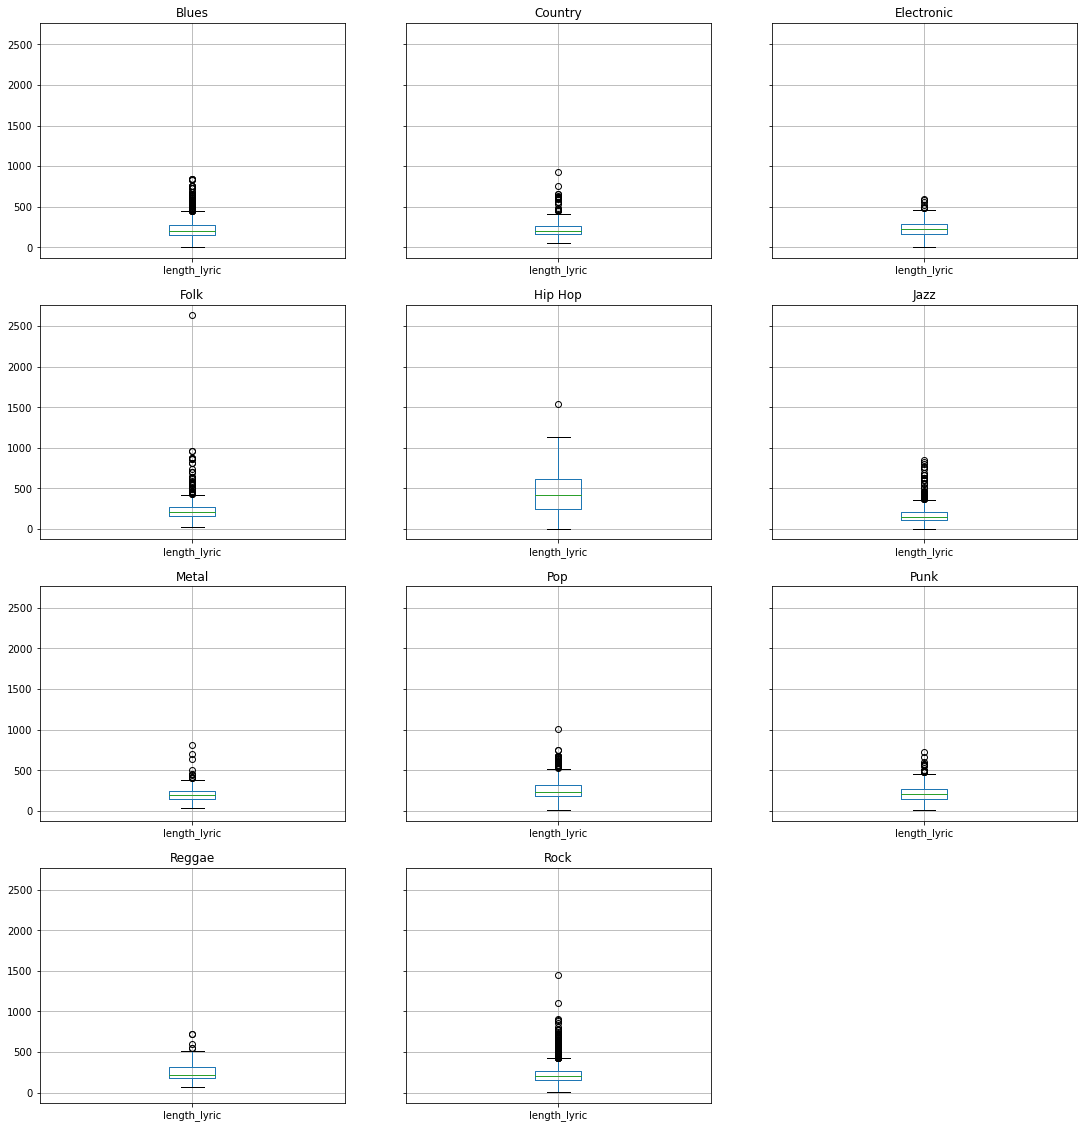

In [11]:
lyrics.groupby('closest_genre').boxplot(figsize=(18,20))

In [12]:
min_sentence_length = lyrics.lyric.apply(lambda x: x.split()).apply(len).min()
min_sentence_length

4

In [13]:
max_sentence_length = lyrics.lyric.apply(lambda x: x.split()).apply(len).max()
max_sentence_length

2634

In [14]:
lyrics_length_threshold = lyrics.lyric.apply(lambda x: x.split()).apply(len).quantile(0.25)
lyrics_length_threshold

149.0

In [15]:
cleaned_lyrics = lyrics[(lyrics.length_lyric>=lyrics_length_threshold)]
threshold = cleaned_lyrics.groupby('closest_genre')['song_name'].nunique()['Metal']
cleaned_lyrics = cleaned_lyrics[cleaned_lyrics.closest_genre!='Reggae']
cleaned_lyrics = cleaned_lyrics.groupby('closest_genre').sample(n=threshold, random_state=RANDOM_SEED)

In [16]:
cleaned_lyrics.groupby('closest_genre')['song_name'].nunique().sort_values()

closest_genre
Metal         193
Country       195
Electronic    196
Jazz          196
Folk          198
Blues         199
Pop           200
Hip Hop       204
Punk          204
Rock          207
Name: song_name, dtype: int64

In [17]:
cleaned_lyrics.groupby('closest_genre')['song_name'].nunique()

closest_genre
Blues         199
Country       195
Electronic    196
Folk          198
Hip Hop       204
Jazz          196
Metal         193
Pop           200
Punk          204
Rock          207
Name: song_name, dtype: int64

In [18]:
cleaned_lyrics.groupby('closest_genre')['song_name'].sum()

closest_genre
Blues         Tears Dry On Their OwnPsychedelic ShackI'm You...
Country       I Want Your Love - 2018 RemasterNext in LineMe...
Electronic    Cool Cat - Remastered 2011Cool CatBohemian Rha...
Folk          All My TrialsCopperhead RoadDeath Letter Blues...
Hip Hop       Rebirth Of Slick (Cool Like Dat)RosesLoserNo T...
Jazz          Recipe For LoveThese Boots Are Made For Walkin...
Metal         Narcosynthesis - live at the Zeche Bochum, Ger...
Pop           Whenever, WhereverI've Got the Music in MeLet ...
Punk          Vampires Will Never Hurt YouPersonality Crisis...
Rock          She Will Be Loved - Radio MixDaisy JaneAshes t...
Name: song_name, dtype: object

In [19]:
length_of_lyrics_per_genre = {}
for i, a in cleaned_lyrics.groupby('closest_genre')['lyric'].sum().iteritems():
    length_of_lyrics_per_genre[i] = len(a)

In [20]:
length_of_lyrics_per_genre

{'Blues': 262897,
 'Country': 256713,
 'Electronic': 265913,
 'Folk': 279209,
 'Hip Hop': 498608,
 'Jazz': 244479,
 'Metal': 264776,
 'Pop': 289343,
 'Punk': 273657,
 'Rock': 250262}

<BarContainer object of 10 artists>

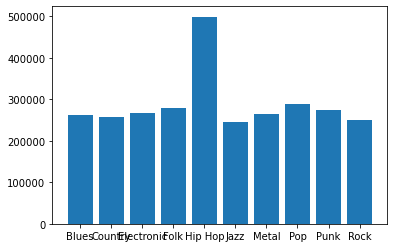

In [21]:
plt.bar(length_of_lyrics_per_genre.keys(), length_of_lyrics_per_genre.values())

In [22]:
unique_words_per_genre = {}
length_unique_words_per_genre = {}
for genre, lyric in cleaned_lyrics.groupby('closest_genre')['lyric'].sum().iteritems():
    text = lyric.lower()
    tokens = wordpunct_tokenize(text)
    unique_words_per_genre[genre] = set(tokens)
    length_unique_words_per_genre[genre] = len(set(tokens))

<BarContainer object of 10 artists>

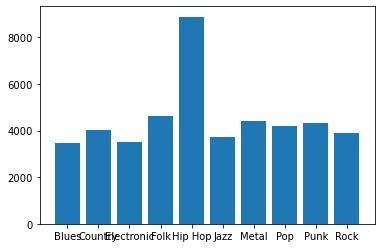

In [23]:
plt.bar(length_unique_words_per_genre.keys(), length_unique_words_per_genre.values())

In [24]:
freq_unique_words_per_genre = {}
stop_words = stopwords.words('english')
sentences = []
for genre, lyric in cleaned_lyrics.groupby('closest_genre')['lyric'].sum().iteritems():
    text = lyric.lower()
    tokens = wordpunct_tokenize(text)
    # filtered_sentence = [w for w in tokens if (not w in stop_words) and (w.isalpha())] 
    filtered_sentence = [w for w in tokens if (w.isalpha())] 
    sentences += filtered_sentence
    fdist1 = nltk.FreqDist(filtered_sentence)
    freq_unique_words_per_genre[genre] = dict((word, freq) for word, freq in fdist1.items() if word.isalpha())


In [25]:
sentences_1 = [sent.split() for sent in sentences]

In [26]:
sentences_1[:10]

[['all'],
 ['i'],
 ['can'],
 ['ever'],
 ['be'],
 ['to'],
 ['you'],
 ['is'],
 ['a'],
 ['darkness']]

In [27]:
common_terms = []
for key in freq_unique_words_per_genre.keys():
    common_terms += heapq.nlargest(1000, freq_unique_words_per_genre[key], key=freq_unique_words_per_genre[key].get)
common_terms = set(common_terms)

In [28]:
len(common_terms)

2924

In [290]:
from gensim.models.phrases import Phrases, Phraser

In [340]:
phrases = Phrases(sentences_1, common_terms=common_terms, min_count=10)
ngram = Phraser(phrases)

INFO - 17:28:34: collecting all words and their counts
INFO - 17:28:34: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 17:28:34: PROGRESS: at sentence #10000, processed 10000 words and 332 word types
INFO - 17:28:35: PROGRESS: at sentence #20000, processed 20000 words and 603 word types
INFO - 17:28:35: PROGRESS: at sentence #30000, processed 30000 words and 951 word types
INFO - 17:28:35: PROGRESS: at sentence #40000, processed 40000 words and 1182 word types
INFO - 17:28:35: PROGRESS: at sentence #50000, processed 50000 words and 1400 word types
INFO - 17:28:35: PROGRESS: at sentence #60000, processed 60000 words and 1712 word types
INFO - 17:28:35: PROGRESS: at sentence #70000, processed 70000 words and 2020 word types
INFO - 17:28:35: PROGRESS: at sentence #80000, processed 80000 words and 2292 word types
INFO - 17:28:35: PROGRESS: at sentence #90000, processed 90000 words and 2577 word types
INFO - 17:28:35: PROGRESS: at sentence #100000, processed 100000 word

In [341]:
ngrams_sent = list(ngram[sentences_1])

In [342]:
ngrams_sent.append(['paddingkosong'])
ngrams_sent.append(['tidakdiketahui'])

- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
- size = int - Dimensionality of the feature vectors. - (50, 300)
- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
- alpha = float - The initial learning rate - (0.01, 0.05)
- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To - set it: alpha - (min_alpha * epochs) ~ 0.00
- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [294]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [366]:
w2v_model = Word2Vec(min_count=1,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=0,
                     workers=cores-1)

In [367]:
t = time()

w2v_model.build_vocab(ngrams_sent, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:49:53: collecting all words and their counts
INFO - 17:49:53: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:49:53: PROGRESS: at sentence #1000, processed 1000 words, keeping 299 word types
INFO - 17:49:53: PROGRESS: at sentence #2000, processed 2000 words, keeping 446 word types
INFO - 17:49:53: PROGRESS: at sentence #3000, processed 3000 words, keeping 587 word types
INFO - 17:49:53: PROGRESS: at sentence #4000, processed 4000 words, keeping 723 word types
INFO - 17:49:53: PROGRESS: at sentence #5000, processed 5000 words, keeping 847 word types
INFO - 17:49:53: PROGRESS: at sentence #6000, processed 6000 words, keeping 968 word types
INFO - 17:49:53: PROGRESS: at sentence #7000, processed 7000 words, keeping 1052 word types
INFO - 17:49:53: PROGRESS: at sentence #8000, processed 8000 words, keeping 1124 word types
INFO - 17:49:53: PROGRESS: at sentence #9000, processed 9000 words, keeping 1222 word types
INFO - 17:49:53: PROGRESS: at sentence #

In [368]:
phrasest = time()

w2v_model.train(ngrams_sent, total_examples=w2v_model.corpus_count, epochs=50, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 17:49:58: training model with 11 workers on 17678 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=0 window=2
INFO - 17:49:59: worker thread finished; awaiting finish of 10 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 9 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 8 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 7 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 6 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 5 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 4 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 3 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 2 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 1 more threads
INFO - 17:49:59: worker thread finished; awaiting finish of 0 more threads
INFO - 17:49:59: EPOCH - 1 : training o

In [369]:
w2v_model.most_similar('bird')

INFO - 17:50:33: precomputing L2-norms of word weight vectors


[('hangers', 0.24647101759910583),
 ('meon', 0.24188756942749023),
 ('tellin', 0.2213885486125946),
 ('amas', 0.21655596792697906),
 ('woman', 0.2043018341064453),
 ('introduces', 0.20365317165851593),
 ('names', 0.20222358405590057),
 ('television', 0.20033210515975952),
 ('coochie', 0.19856244325637817),
 ('chatter', 0.19513769447803497)]

In [370]:
w2v_model.vector_size

300

In [29]:
# w2v_model.save("fifteenKlyricswv_withstopwords.model")
w2v_model = Word2Vec.load("fifteenKlyricswv_withstopwords.model")

INFO - 18:22:47: loading Word2Vec object from fifteenKlyricswv_withstopwords.model
INFO - 18:22:47: loading wv recursively from fifteenKlyricswv_withstopwords.model.wv.* with mmap=None
INFO - 18:22:47: setting ignored attribute vectors_norm to None
INFO - 18:22:47: loading vocabulary recursively from fifteenKlyricswv_withstopwords.model.vocabulary.* with mmap=None
INFO - 18:22:47: loading trainables recursively from fifteenKlyricswv_withstopwords.model.trainables.* with mmap=None
INFO - 18:22:47: setting ignored attribute cum_table to None
INFO - 18:22:47: loaded fifteenKlyricswv_withstopwords.model


In [377]:
# w2v_model.wv.save('fifteenklyricsvocab_withstopwords.kv')

INFO - 17:52:18: saving Word2VecKeyedVectors object under fifteenklyricsvocab_withstopwords.kv, separately None
INFO - 17:52:18: not storing attribute vectors_norm
INFO - 17:52:18: saved fifteenklyricsvocab_withstopwords.kv


In [30]:
# Pytorch
import torch.nn as nn
import torch.nn.functional as f
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.model_selection import train_test_split

In [31]:
cleaned_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 12869 to 7605
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   artist         2080 non-null   object
 1   song_name      2080 non-null   object
 2   closest_genre  2080 non-null   object
 3   lyric          2080 non-null   object
 4   length_lyric   2080 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 97.5+ KB


In [33]:
embedding_matrix = torch.FloatTensor(w2v_model2.wv.vectors)
embedding_matrix.shape

torch.Size([17678, 300])

In [34]:
word2idx2 = {}
for word in w2v_model.wv.index2word:
    word2idx2[word] = w2v_model2.wv.vocab[word].index

In [35]:
len(w2v_model.wv.vocab)

17678

In [36]:
len(word2idx)

17678

In [37]:
Xs = cleaned_lyrics['lyric']
y = cleaned_lyrics['closest_genre']

In [38]:
Xs

12869    All I can ever be to you is a darkness that we...
9240     Psychedelic shack, that's where it's at\nPsych...
3509     The gypsy woman told my mother\nBefore I was b...
11680    Out of the ruins\nout from the wreckage\n\nCan...
2221     I\nDennis: Can turn a gray sky blue.\nMelvin: ...
                               ...                        
14869    She struts into the room\nWell I don't know he...
868      Deep down Louisiana close to New Orleans,\nWay...
10432    Oh-woah-yay-yay\nI love you more than I can sa...
6867     This name I got we all agreed\nSee could stop ...
7605     ''{spoken} Oh my God! What a fabulous room! Ar...
Name: lyric, Length: 2080, dtype: object

In [39]:
len(word2idx2)

17678

In [40]:
word2idx.get('PAD', 10)

10

In [41]:
word2idx['paddingkosong']

17676

In [42]:
word2idx['tidakdiketahui']

17677

In [43]:
def sentence_encoder(text, vocab2index):
    tokens = text.lower().split()
    # Unknown = 9999
    # Padding = 9998
    temp = np.full(len(vocab2index), vocab2index['paddingkosong'])
    sentencoded = np.array([vocab2index.get(word, vocab2index['tidakdiketahui']) for word in tokens])
    length = len(sentencoded)
    temp[:length] = sentencoded
    return temp

In [44]:
sentence_encoder(Xs[0], word2idx)

array([17677,     5,  3613, ..., 17676, 17676, 17676])

In [45]:
X = Xs.apply(lambda x: sentence_encoder(x, word2idx))
X = X.to_numpy()

In [46]:
TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy(), test_size=TEST_SIZE, random_state=RANDOM_SEED)
_, X_val, _, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [47]:
classes = cleaned_lyrics.closest_genre.unique()
pp.pprint(classes)

array(['Blues', 'Country', 'Electronic', 'Folk', 'Hip Hop', 'Jazz',
       'Metal', 'Pop', 'Punk', 'Rock'], dtype=object)


In [49]:
train_on_gpu = torch.cuda.is_available()
lstm_dict = {
    'batch_size':24,
    'hidden_dim': embedding_matrix.shape[1],
    'lstm_layers':3,
    'input_size':embedding_matrix.shape[0],
    'padding_idx': w2v_model2.wv.vocab['paddingkosong'].index,
}
lstm_args = namedtuple('lstm_args', lstm_dict.keys())(**lstm_dict)


In [50]:
embedding_matrix.shape

torch.Size([17678, 300])

In [51]:
# Simple LSTM Model
# Input size = vocab size = num_embeddings
# hidden dim = embedding_dim = 
class Simple_LSTM(nn.Module):
	def __init__(self, args):
		super(Simple_LSTM, self).__init__()
		
		# Hyperparameters
		self.batch_size = args.batch_size
		self.hidden_dim = args.hidden_dim
		self.LSTM_layers = args.lstm_layers
		self.input_size = args.input_size
		
		self.dropout = nn.Dropout(0.5)
		# self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
		self.embedding = nn.Embedding.from_pretrained(embedding_matrix.cuda(), padding_idx=args.padding_idx, freeze=True)
		self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
		self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim*2)
		self.fc2 = nn.Linear(self.hidden_dim*2, 10)
		
	def forward(self, x):
		
		# Hidden and cell state definion
		h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim)).cuda()
		c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim)).cuda()
		
		# Initialization fo hidden and cell states
		torch.nn.init.xavier_normal_(h)
		torch.nn.init.xavier_normal_(c)

		# Each sequence "x" is passed through an embedding layer
		out = self.embedding(x)
		# Feed LSTMs
		out, (hidden, cell) = self.lstm(out, (h,c))
		out = self.dropout(out)
		# The last hidden state is taken
		out = torch.relu_(self.fc1(out[:,-1,:]))
		out = self.dropout(out)
		out = torch.softmax(self.fc2(out))

		return out

In [52]:
class DatasetMaper(Dataset):
	'''
	Handles batches of dataset
	'''
  
	def __init__(self, x, y):
		self.x = x
		self.y = y
		
	def __len__(self):
		return len(self.x)
		
	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

training_set = DatasetMaper(X_train, y_train)
validation_set = DatasetMaper(X_val, y_val)
test_set = DatasetMaper(X_test, y_test)
		
loader_training = DataLoader(training_set, batch_size=lstm_args.batch_size)
loader_val = DataLoader(training_set, batch_size=lstm_args.batch_size)
loader_test = DataLoader(test_set)

In [53]:
WARMUP_STEPS=500
WARMUP_FACTOR = 1.0 / 3.0
GLOBAL_STEPS=0
LR_INIT=0.01
def train_model(model, train_dl,val_dl, epochs=10, lr=0.01):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.SGD(model.parameters(),lr =lr,momentum=0.9,weight_decay=0.0001)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y in train_dl:
            x = torch.tensor(x).to(torch.long).cuda()
            y_pred = model(x)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        torch.cuda.empty_cache()
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc))


In [54]:
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y in valid_dl:
        x = x.cuda()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    torch.cuda.empty_cache()
    return sum_loss/total, correct/total, sum_rmse/total

In [55]:
model = Simple_LSTM(lstm_args).cuda()

In [1]:
train_model(model, loader_training,loader_val, epochs=5, lr=0.01)

In [459]:
 torch.cuda.empty_cache()